In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_regression, RFE, f_classif

from scipy.stats.mstats import winsorize

### Functions for the dataset

In [12]:
# Function to check outlier in all the columns

def outlier_ondeck(data):
    cols = data.select_dtypes(include='number').columns.tolist()

    for i in cols:
        sns.boxplot(data[i])
        plt.show()

In [13]:
#Checking the Quartiles of each column

def iqr_out(data):
    
    x = pd.DataFrame(columns=['Features','No. of Outliers'])
    
    out = list(data)
    
    cols = data.select_dtypes(include='number').columns.tolist()
    
    cols.remove('ID')
    cols.remove('region_code')
#     for i in cols:
#         if i == 'cc_cons':
#             cols.remove('cc_cons')
#         else:
#             continue

    for i in out:
        if i in cols:
            Q1 = data[i].quantile(0.25)
            Q3 = data[i].quantile(0.75)
            IQR = Q3 - Q1

            up_b = Q3 + 1.5 * IQR
            low_b = Q3 - 1.5 * IQR

            x = x.append({
                'Features':i,
                'No. of Outliers':data.loc[(data[i] < low_b) | (data[i] > up_b)].shape[0]
            },ignore_index=True)
    return x

In [14]:
# Function to check the distribution of required features

def Dist(data):
    colus = data.select_dtypes(include='number').columns.tolist()
    
    colus.remove('ID')
    colus.remove('region_code')
#     colus.remove('age')

    for i in colus:
        plt.figure(figsize=[12,5])
        sns.distplot(data[i])
        plt.axvline(data[i].mean(), color='r')
        plt.axvline(data[i].median(), color='g')
        plt.show()

In [15]:
# Function to treat outliers 

def treatout(x):
    out = list(x)
    
    cols = x.select_dtypes(include='number').columns.tolist()
    
    cols.remove('ID')
    cols.remove('region_code')
    for i in cols:
        if i == 'cc_cons':
            cols.remove('cc_cons')
        else:
            continue
#     cols.remove('investment_4')
#     cols.remove('max_credit_amount_jun')
    
    for i in out:
        if i in cols:
            x[i] = winsorize(x[i], limits=[0.15, 0.15],inclusive=(True, True))
    
    return x

In [16]:
# Function to treat outliers below 0 level (investment_4)

def low_out(x, col):
    x[col] = winsorize(x[col], limits=[0.3,0.001], inclusive=(True,True))

In [17]:
# Function to normalize data file

def norm(data):
    col_r = data.select_dtypes(include='number').columns.tolist()
    
    col_r.remove('ID')
    col_r.remove('age')
    col_r.remove('region_code')
    
    
#     for i in col_r:
#         if i == 'cc_cons':
#             col_r.remove('cc_cons')
#         else:
#             continue

    data[col_r] = np.log1p(data[col_r])

In [18]:
# Root Mean Squared Logarithmic Error

def rmsle(y_test, y_pred):
    
    sum=0.0
    
    for x,y in zip(y_test, y_pred):
        if x < 0 or y < 0: #Check for negative values
            continue
    
        p = np.log(x+1)
        q = np.log(y+1)
    
        sum += (p - q)**2
    
    return (sum / len(y_pred))**0.5

In [19]:
# Function to encode categorical data

def encode(data):
    enc = LabelEncoder()
    
    cols = data.select_dtypes(include='object')
    for i in cols:
        data[i] = enc.fit_transform(data[i])

    return data.head()

In [21]:
# Function to save the predictions in a csv file

def save_to_csv(data):
    df = pd.DataFrame()
    df['ID'] = data['ID']
    df['cc_cons'] = y_pred
    try:
        df.to_csv(r"C:\Users\ckatkaa\Desktop\jupyter notebook\Hackathon\final\output.csv", index=False)
        print("\n")
        print("csv successfully saved. \n")


    except Error as e:
        print(e)

#### Load the training set

In [22]:
data = pd.read_csv(r'C:\Users\ckatkaa\Desktop\jupyter notebook\Hackathon\Train.csv')

#### Load the test data

In [23]:
df = pd.read_csv(r'C:\Users\ckatkaa\Desktop\jupyter notebook\Hackathon\Test.csv')

In [24]:
data.head()

,ID,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,...,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,cc_cons
0,12554,current,M,35,708,24893.00,378.00,10288.00,29664.00,16291.40,...,40.0,24563.0,30051.32,12761.0,2.0,65.0,50836.0,Y,1674.09,20014.0
1,17645,current,M,35,123,18941.62,966.00,20672.00,287.00,4217.00,...,78.0,23948.0,42119.05,76206.0,21.0,63.0,23226.0,Y,13043.34,10173.0
2,7604,current,M,55,802,5678.87,2724.00,1964.50,3933.11,23956.25,...,82.0,10752.0,58373.25,75283.0,7.0,1.0,27036.0,Y,25375.27,16095.0
3,1590,current,F,29,867,30489.50,1236.00,12609.88,9138.14,17521.00,...,38.0,12607.0,69851.51,68708.0,21.0,83.0,43037.0,Y,3544.33,7707.0
4,16556,current,M,34,802,7441.40,6906.04,4364.00,1939.00,2121.00,...,50.0,25213.0,10071.00,80140.0,8.0,32.0,32044.0,Y,12780.44,96408.0


In [25]:
dictionary = pd.read_excel(r'C:\Users\ckatkaa\Desktop\jupyter notebook\Hackathon\Data_Dictionary.xlsx')

In [26]:
dictionary

,Variable,Description
0,ID,Unique ID for every Customer
1,account_type,Account Type – current or saving
2,gender,Gender of customer
3,age,Age of customer
4,region_code,Code assigned to region of residence (has order)
5,cc_cons_apr,Credit card spend in April
6,dc_cons_apr,Debit card spend in April
7,cc_cons_may,Credit card spend in May
8,dc_cons_may,Debit card spend in May
9,cc_cons_jun,Credit card spend in June


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 44 columns):
ID                       15000 non-null int64
account_type             15000 non-null object
gender                   15000 non-null object
age                      15000 non-null int64
region_code              15000 non-null int64
cc_cons_apr              15000 non-null float64
dc_cons_apr              15000 non-null float64
cc_cons_may              15000 non-null float64
dc_cons_may              15000 non-null float64
cc_cons_jun              15000 non-null float64
dc_cons_jun              15000 non-null float64
cc_count_apr             15000 non-null float64
cc_count_may             15000 non-null float64
cc_count_jun             15000 non-null float64
dc_count_apr             15000 non-null float64
dc_count_may             15000 non-null float64
dc_count_jun             15000 non-null float64
card_lim                 15000 non-null float64
personal_loan_active     15000 non-

In [28]:
data.describe()

,ID,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,...,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,1.500000e+04,15000.000000
mean,10032.077067,47.790600,598.415467,17957.391719,8171.098287,1.633705e+04,7703.605203,12129.010832,7097.395321,41.488333,...,11.923133,40.996867,5.718791e+04,7.615987e+04,7.850316e+04,19.946400,44.647867,5.258654e+04,1.576040e+04,55157.729867
std,5760.372343,30.632766,220.062345,25187.939958,14773.029481,2.706085e+04,18987.296785,18488.781136,13251.695907,97.432251,...,16.843563,40.537354,2.000194e+05,1.545112e+05,1.482005e+05,27.200165,35.089082,1.282601e+05,1.179153e+05,97670.972252
min,1.000000,25.000000,123.000000,253.000000,19.350000,1.570000e+02,22.000000,65.000000,62.000000,1.000000,...,0.000000,0.000000,2.500000e-01,5.230000e+00,1.188000e+01,1.000000,0.000000,6.000000e-02,0.000000e+00,0.000000
25%,5060.500000,33.000000,424.000000,4411.027500,1634.000000,3.638000e+03,1643.500000,3004.500000,1358.750000,5.000000,...,2.000000,11.000000,2.008300e+04,2.573259e+04,2.492008e+04,4.000000,12.000000,1.903800e+04,1.548510e+03,6768.000000
50%,10054.000000,40.000000,623.000000,10288.100000,3996.900000,8.695030e+03,3820.500000,6655.250000,3327.000000,10.000000,...,4.000000,23.000000,3.140300e+04,4.580365e+04,4.590000e+04,7.000000,38.000000,3.042550e+04,3.954430e+03,13364.000000
75%,15015.250000,53.000000,799.000000,21405.000000,9339.020000,1.895130e+04,8212.000000,14247.000000,7597.000000,44.000000,...,11.000000,69.000000,5.598600e+04,8.461910e+04,8.559233e+04,21.000000,73.000000,5.321100e+04,9.376390e+03,20105.750000
max,19998.000000,223.000000,974.000000,441031.330000,229255.000000,1.117246e+06,911223.490000,382914.100000,233384.000000,531.000000,...,71.000000,171.000000,1.000000e+07,6.539810e+06,6.611953e+06,117.000000,133.000000,5.200000e+06,7.447125e+06,408382.000000


#### Check for Outliers

###### Training set

In [29]:
# Average expenditure for Credit card and Debit card
data['cc_cons_avg'] = (data['cc_cons_apr'] + data['cc_cons_may'] + data['cc_cons_jun'])/3
data['dc_cons_avg'] = (data['dc_cons_apr'] + data['dc_cons_may'] + data['dc_cons_jun'])/3

data['cc_count_avg'] = (data['cc_count_apr'] + data['cc_count_may'] + data['cc_count_jun'])/3
data['dc_count_avg'] = (data['dc_count_apr'] + data['dc_count_may'] + data['dc_count_jun'])/3

data['invest_avg'] = (data['investment_1'] + data['investment_2'] + data['investment_3'] + data['investment_4'])/4

data['credit_amount_avg'] = (data['credit_amount_apr'] + data['credit_amount_may'] + data['credit_amount_jun'])/3
data['debit_amount_avg'] = (data['debit_amount_apr'] + data['debit_amount_may'] + data['debit_amount_jun'])/3

data['credit_count_avg'] = (data['credit_count_apr'] + data['credit_count_may'] + data['credit_count_jun'])/3
data['debit_count_avg'] = (data['debit_count_apr'] + data['debit_count_may'] + data['debit_count_jun'])/3

data['max_credit_amount_avg'] = (data['max_credit_amount_apr'] + data['max_credit_amount_may'] + data['max_credit_amount_jun'])/3

In [30]:
data.drop(['personal_loan_active',
        'vehicle_loan_active',
        'personal_loan_closed',
        'vehicle_loan_closed','cc_cons_apr', 'cc_cons_may', 'cc_cons_jun',
    'dc_cons_apr', 'dc_cons_may', 'dc_cons_jun',
    'cc_count_apr','cc_count_may','cc_count_jun',
    'dc_count_apr','dc_count_may','dc_count_jun',
    'investment_1', 'investment_2', 'investment_3', 'investment_4',
    'debit_amount_apr','debit_amount_may','debit_amount_jun',
    'credit_amount_apr','credit_amount_may','credit_amount_jun',
    'debit_count_apr','debit_count_may','debit_count_jun',
    'credit_count_apr','credit_count_may','credit_count_jun',
    'max_credit_amount_apr','max_credit_amount_may','max_credit_amount_jun',
        ], axis=1, inplace=True)

###### Testing set

In [31]:
# Average expenditure for Credit card and Debit card
df['cc_cons_avg'] = (df['cc_cons_apr'] + df['cc_cons_may'] + df['cc_cons_jun'])/3
df['dc_cons_avg'] = (df['dc_cons_apr'] + df['dc_cons_may'] + df['dc_cons_jun'])/3

df['cc_count_avg'] = (df['cc_count_apr'] + df['cc_count_may'] + df['cc_count_jun'])/3
df['dc_count_avg'] = (df['dc_count_apr'] + df['dc_count_may'] + df['dc_count_jun'])/3

df['invest_avg'] = (df['investment_1'] + df['investment_2'] + df['investment_3'] + df['investment_4'])/4

df['credit_amount_avg'] = (df['credit_amount_apr'] + df['credit_amount_may'] + df['credit_amount_jun'])/3
df['debit_amount_avg'] = (df['debit_amount_apr'] + df['debit_amount_may'] + df['debit_amount_jun'])/3

df['credit_count_avg'] = (df['credit_count_apr'] + df['credit_count_may'] + df['credit_count_jun'])/3
df['debit_count_avg'] = (df['debit_count_apr'] + df['debit_count_may'] + df['debit_count_jun'])/3

df['max_credit_amount_avg'] = (df['max_credit_amount_apr'] + df['max_credit_amount_may'] + df['max_credit_amount_jun'])/3

In [32]:
df.drop(['personal_loan_active',
        'vehicle_loan_active',
        'personal_loan_closed',
        'vehicle_loan_closed','cc_cons_apr', 'cc_cons_may', 'cc_cons_jun',
    'dc_cons_apr', 'dc_cons_may', 'dc_cons_jun',
    'cc_count_apr','cc_count_may','cc_count_jun',
    'dc_count_apr','dc_count_may','dc_count_jun',
    'investment_1', 'investment_2', 'investment_3', 'investment_4',
    'debit_amount_apr','debit_amount_may','debit_amount_jun',
    'credit_amount_apr','credit_amount_may','credit_amount_jun',
    'debit_count_apr','debit_count_may','debit_count_jun',
    'credit_count_apr','credit_count_may','credit_count_jun',
    'max_credit_amount_apr','max_credit_amount_may','max_credit_amount_jun',
        ], axis=1, inplace=True)

### Univariate Analysis for outlliers

### Outliers in each feature

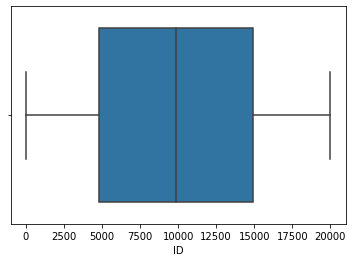

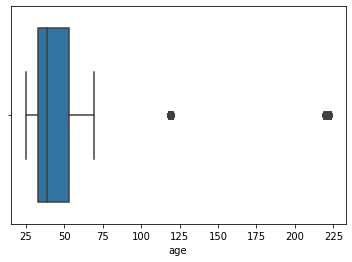

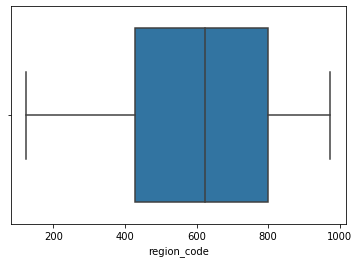

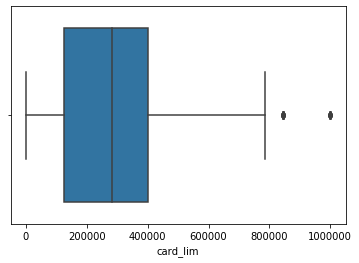

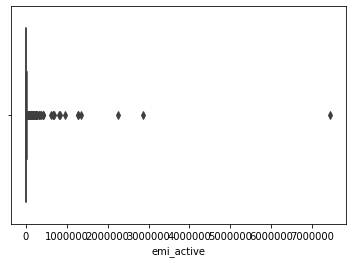

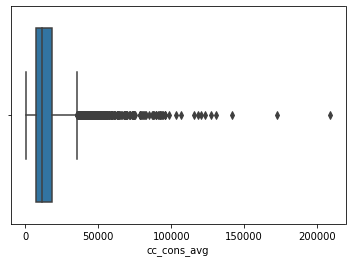

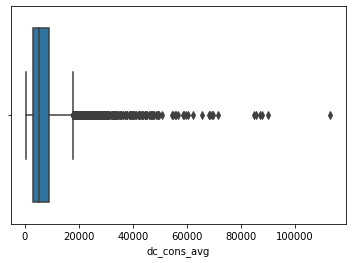

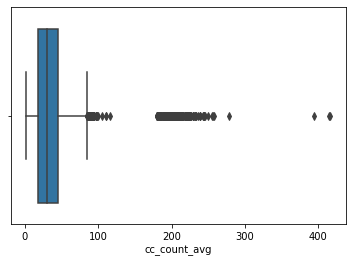

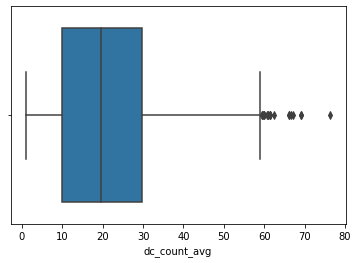

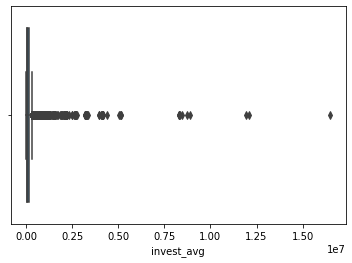

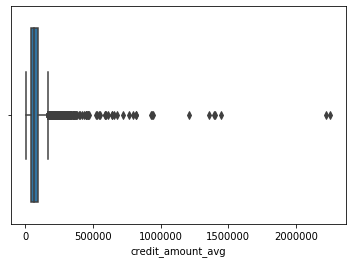

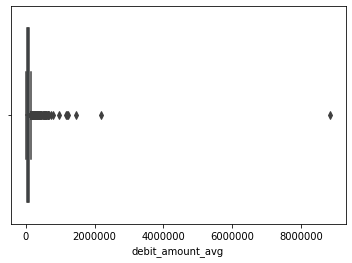

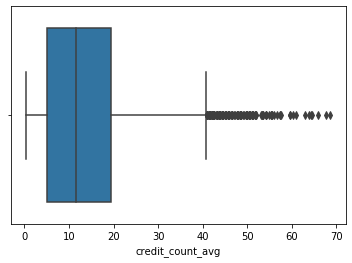

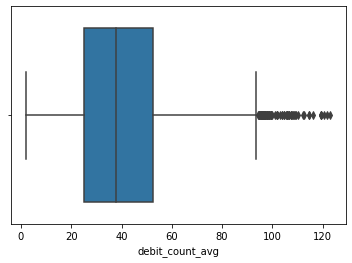

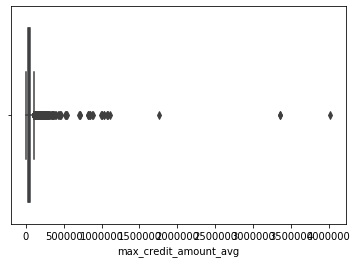

In [33]:
outlier_ondeck(df)

### Outlier Treatment

#### Inter Quartile Region

Train data

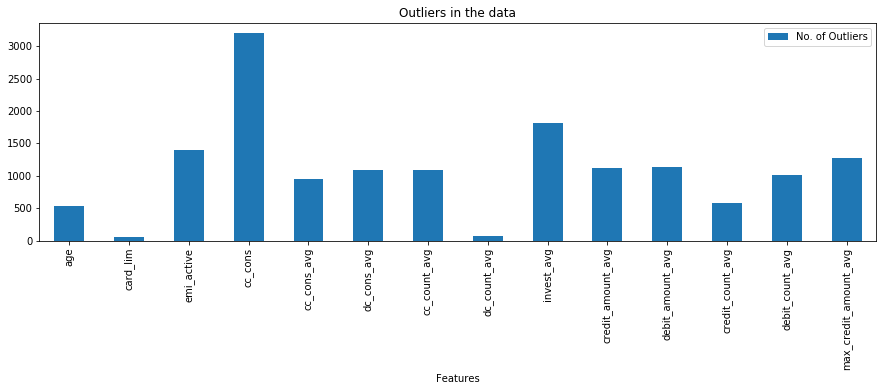

In [34]:
iqr_out(data).set_index('Features').plot(kind='bar',figsize=[15,4])
plt.title('Outliers in the data')
plt.show()

Test set

In [35]:
iqr_out(df)

,Features,No. of Outliers
0,age,172
1,card_lim,28
2,emi_active,447
3,cc_cons_avg,320
4,dc_cons_avg,371
5,cc_count_avg,409
6,dc_count_avg,19
7,invest_avg,580
8,credit_amount_avg,368
9,debit_amount_avg,362


#### Distribution of data in each feature

Train set

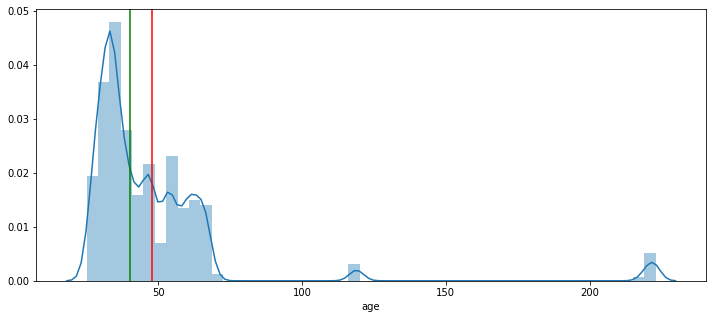

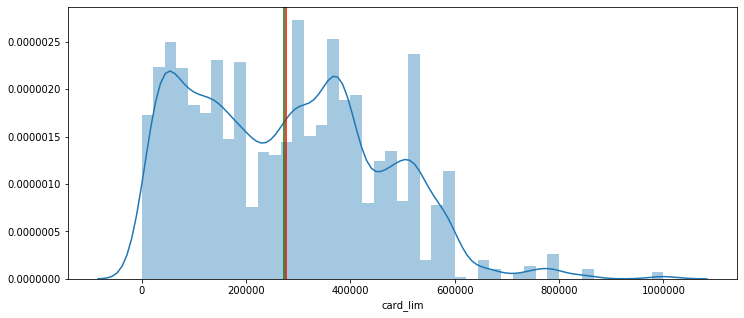

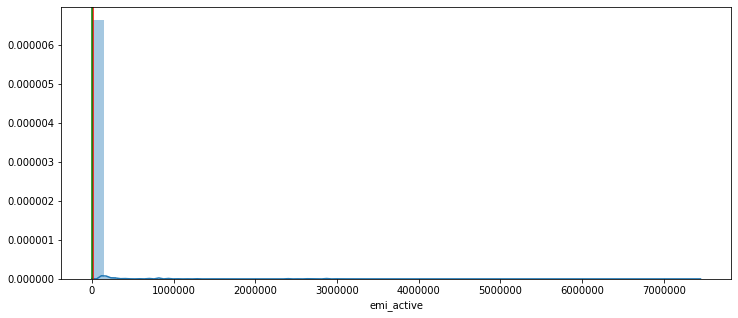

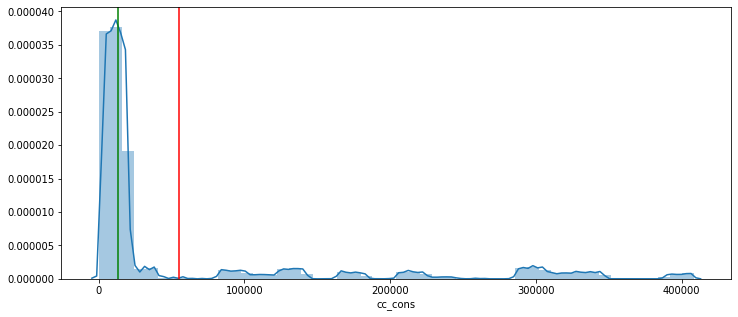

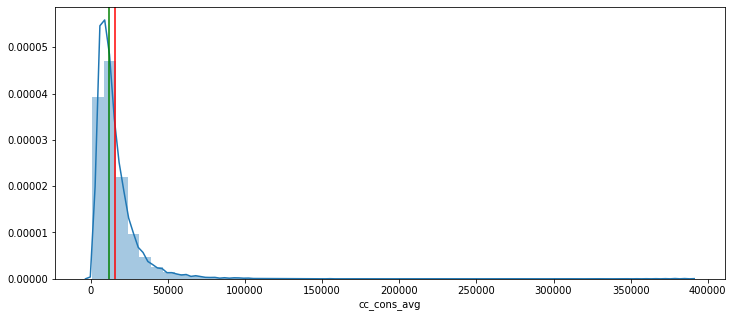

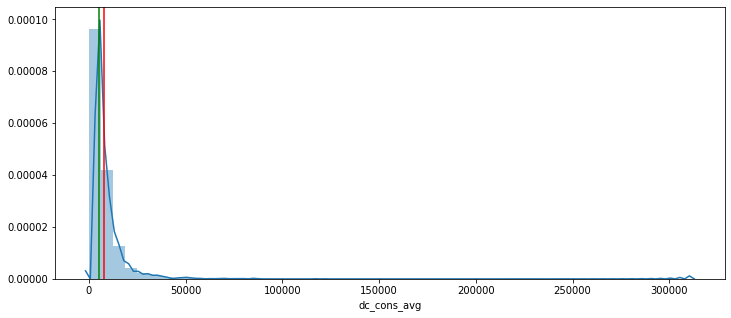

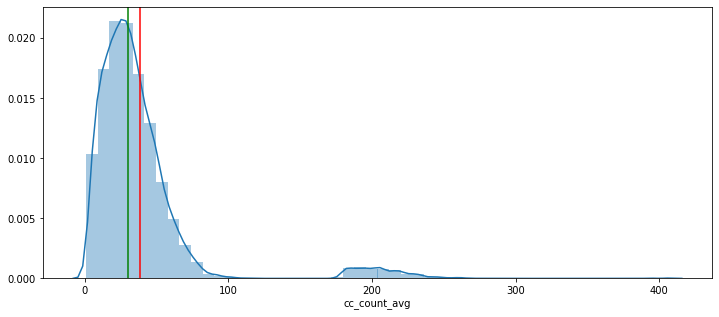

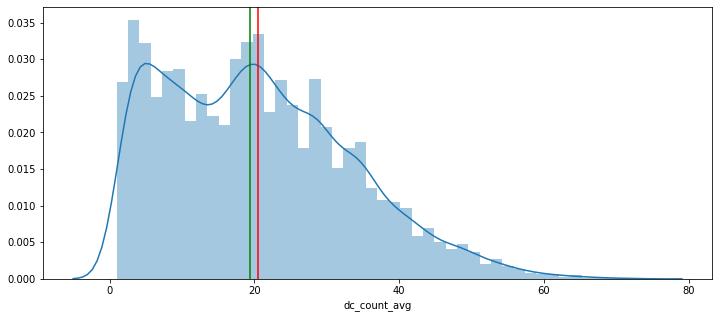

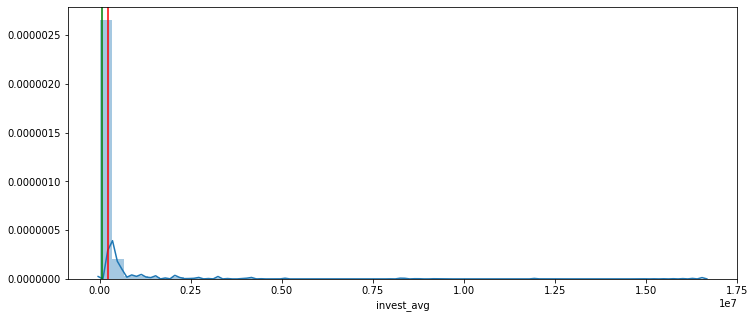

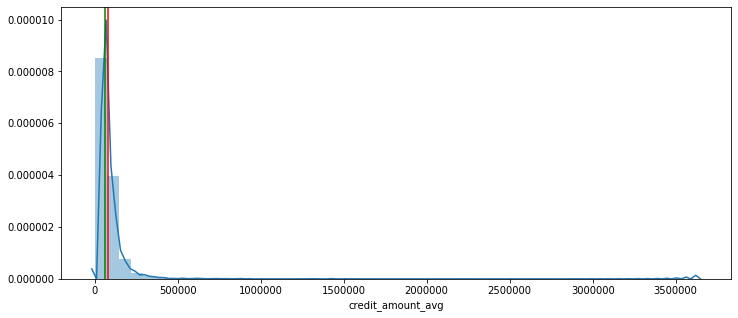

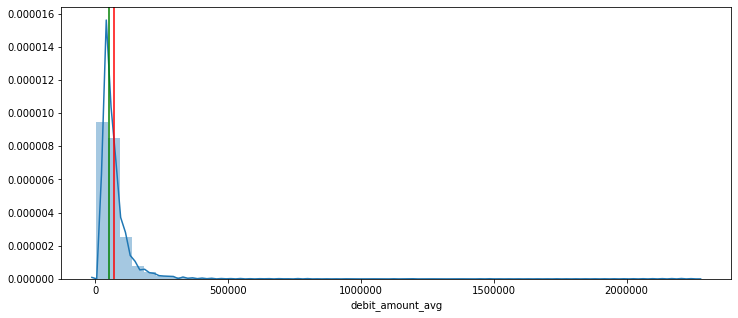

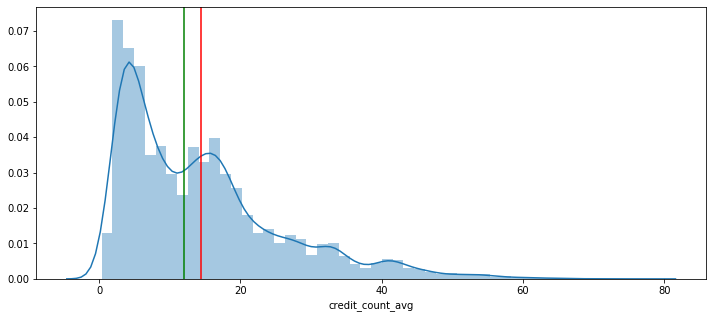

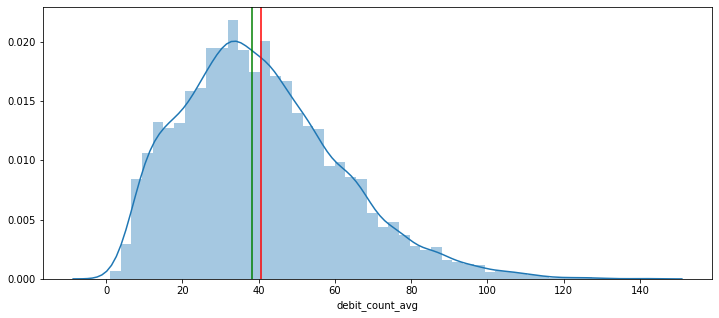

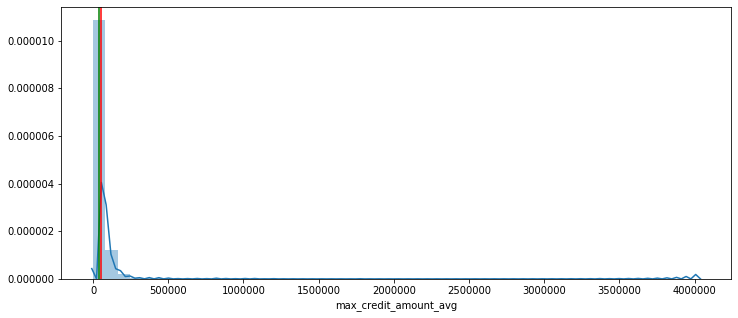

In [36]:
Dist(data)

Test set

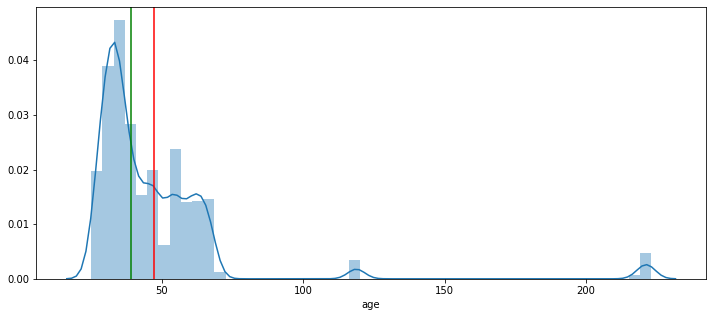

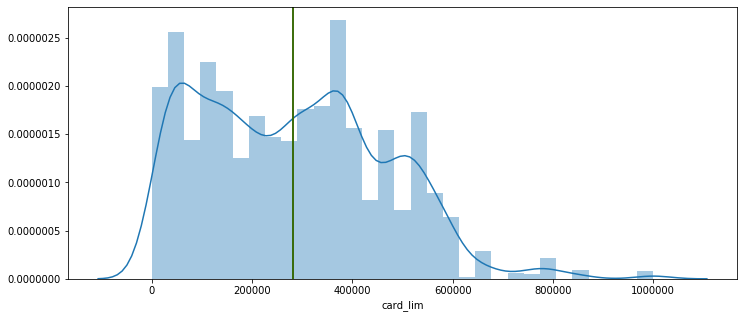

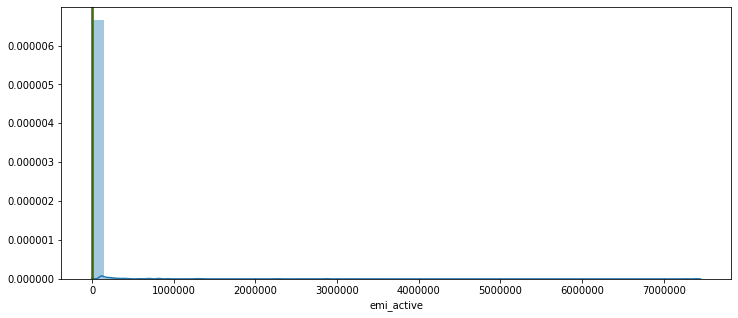

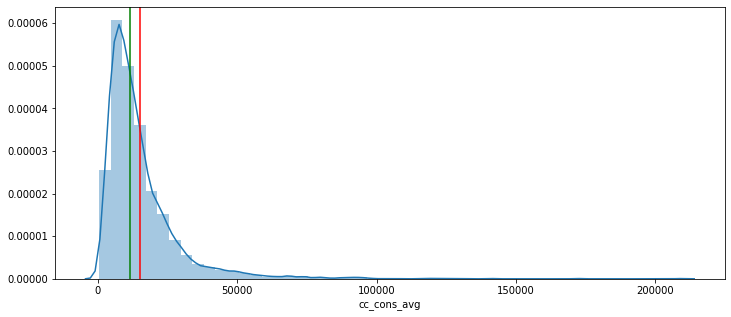

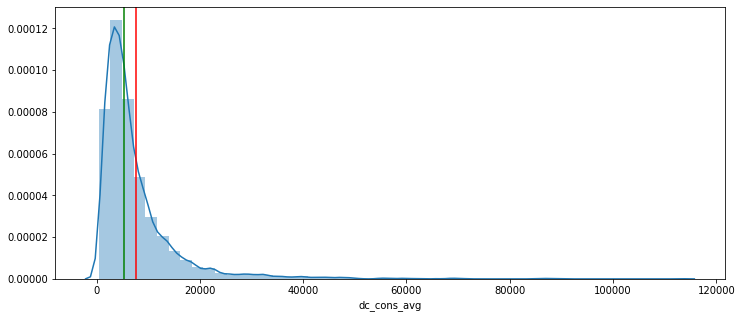

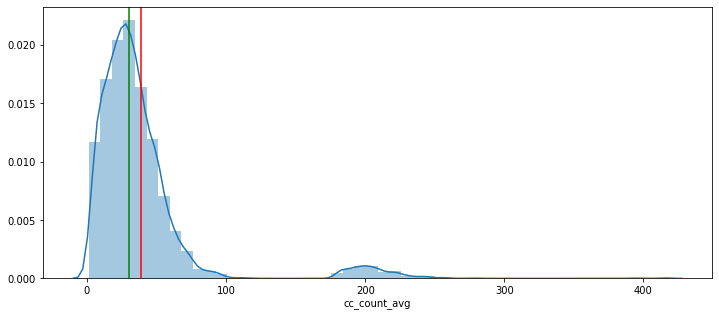

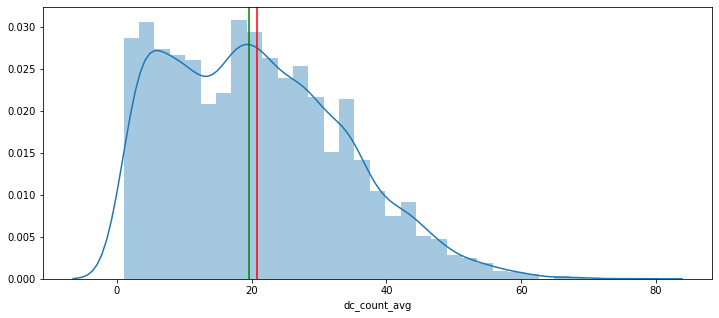

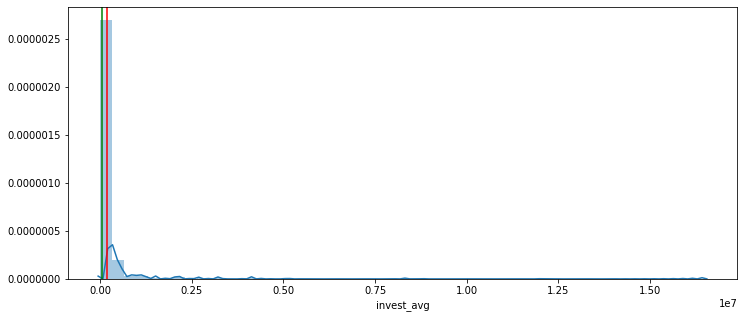

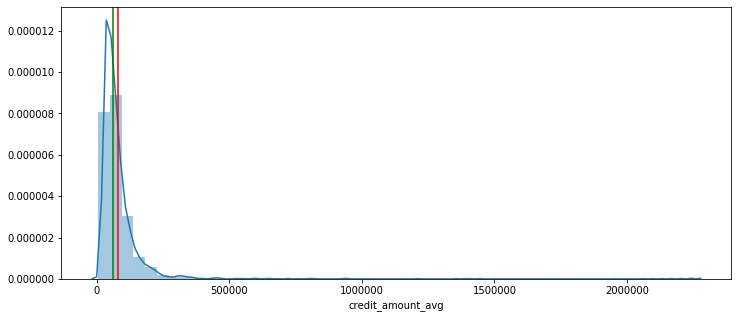

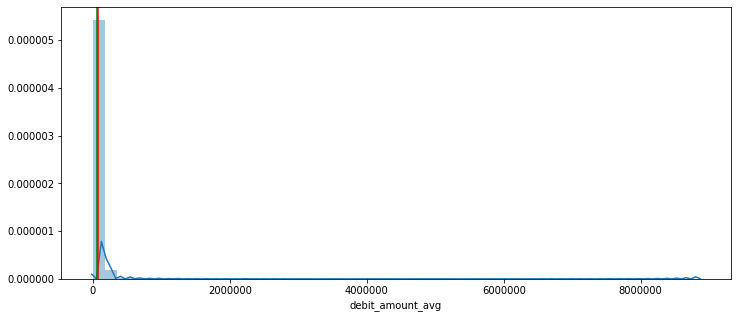

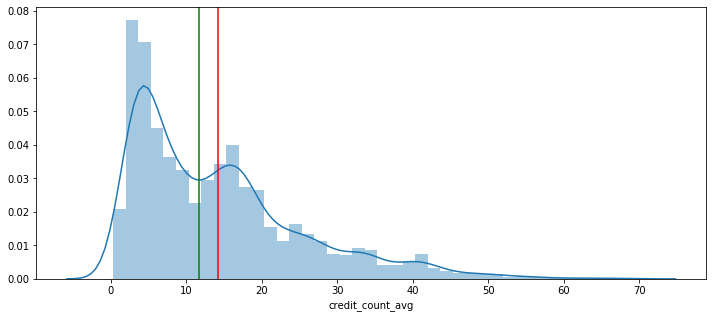

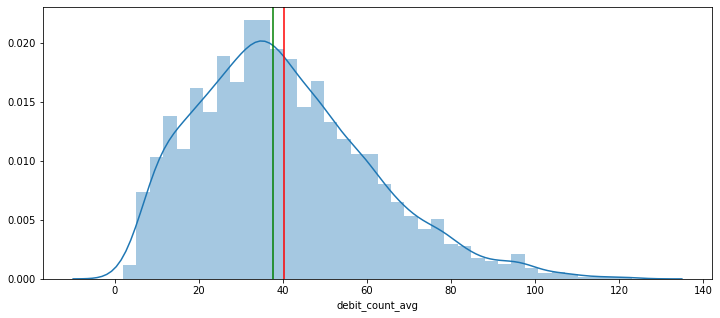

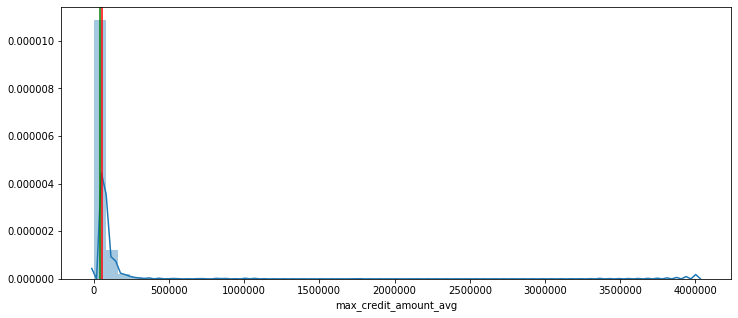

In [37]:
Dist(df)

##### Treatment for all the features in the dataset

Train set

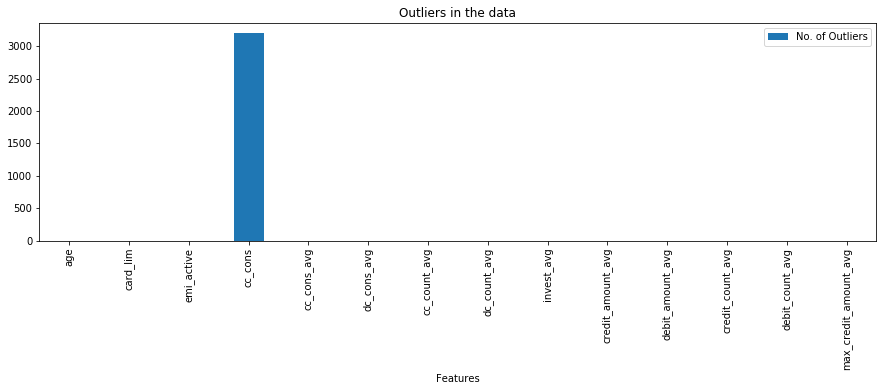

In [38]:
data = treatout(data)

# Checking for outliers after applying winsorization

iqr_out(data).set_index('Features').plot(kind='bar',figsize=[15,4])
plt.title('Outliers in the data')
plt.show()

Test set

In [39]:
df = treatout(df)

# Checking for outliers after applying winsorization
iqr_out(df)

,Features,No. of Outliers
0,age,0
1,card_lim,0
2,emi_active,0
3,cc_cons_avg,0
4,dc_cons_avg,0
5,cc_count_avg,0
6,dc_count_avg,0
7,invest_avg,0
8,credit_amount_avg,0
9,debit_amount_avg,0


###### Dropping features

### Data Distribution

###### Distribution of data for training set

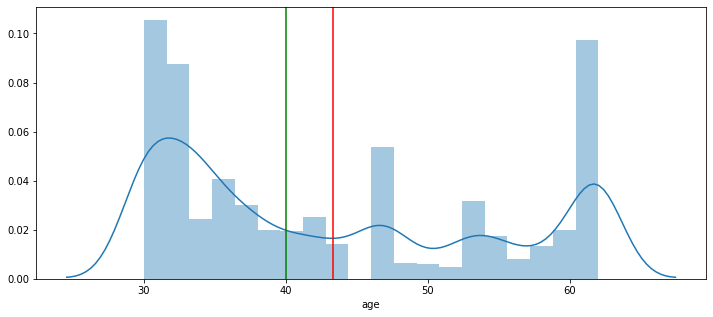

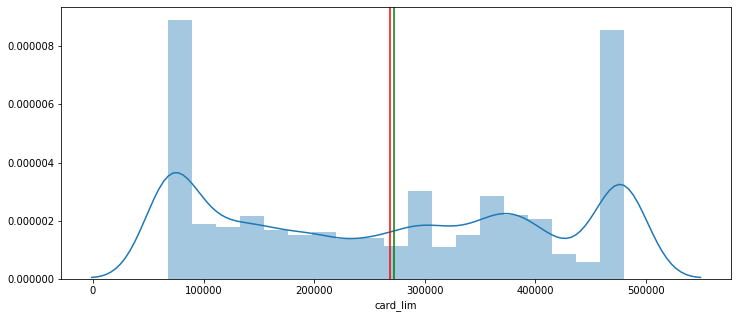

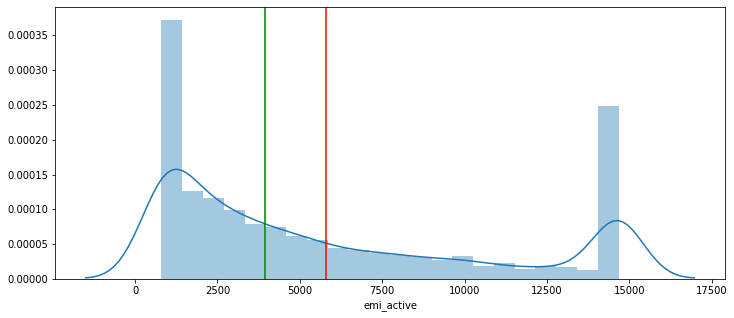

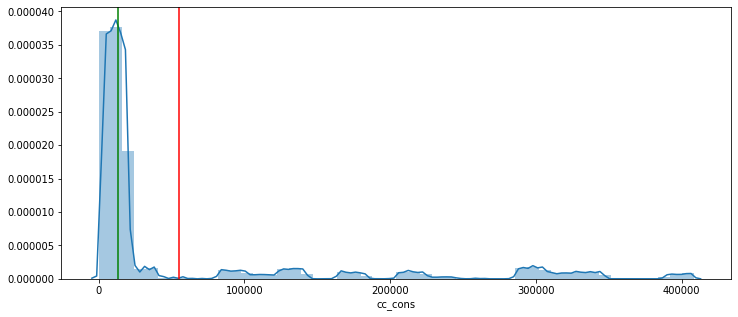

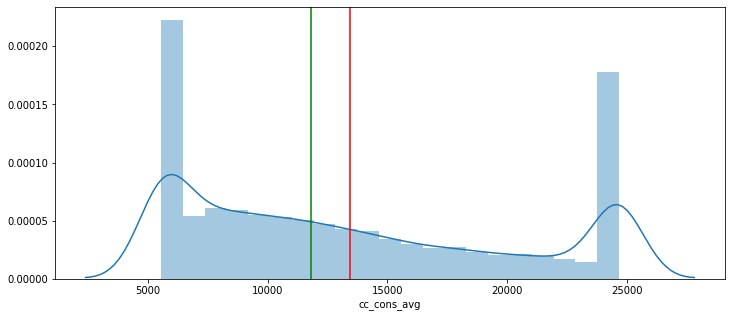

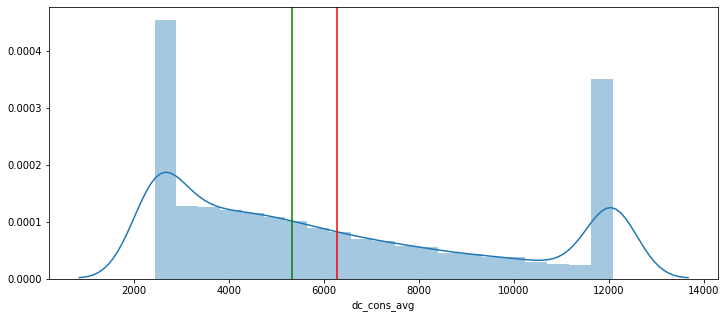

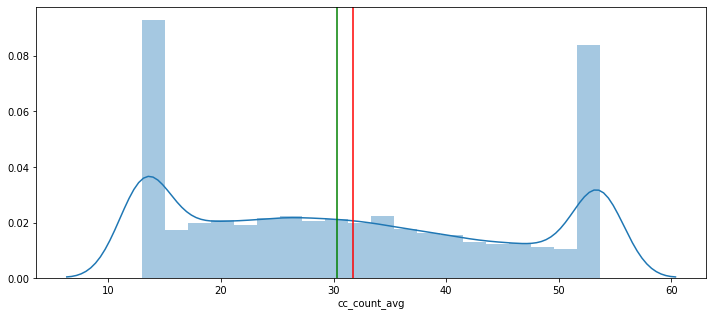

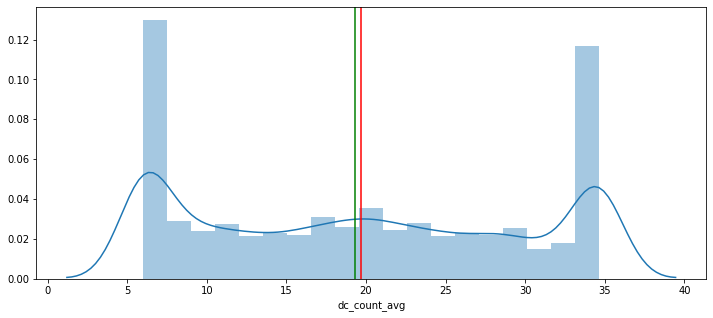

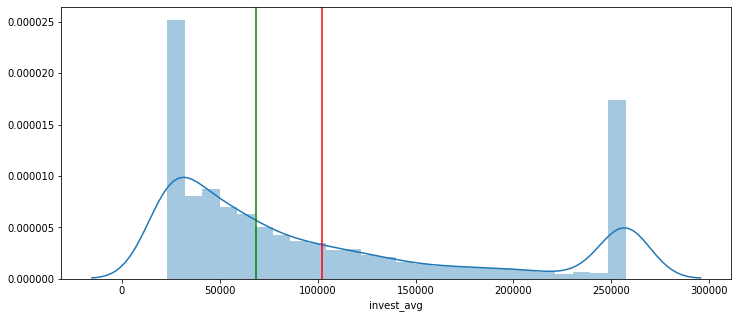

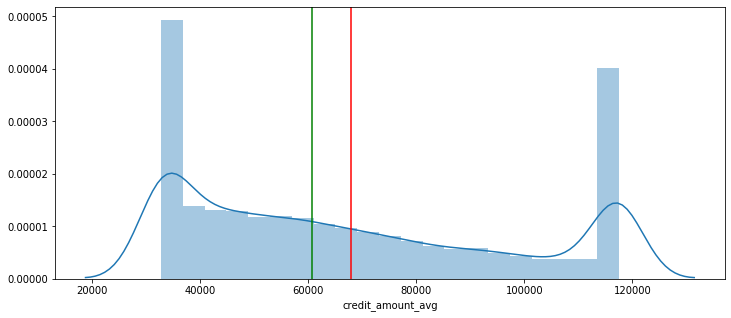

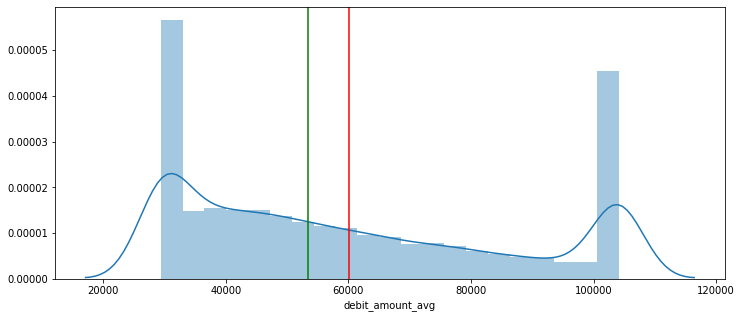

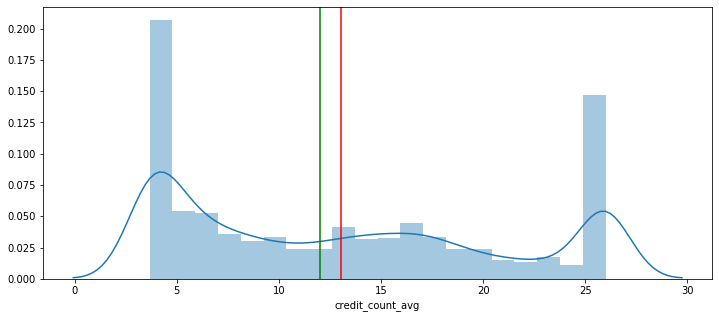

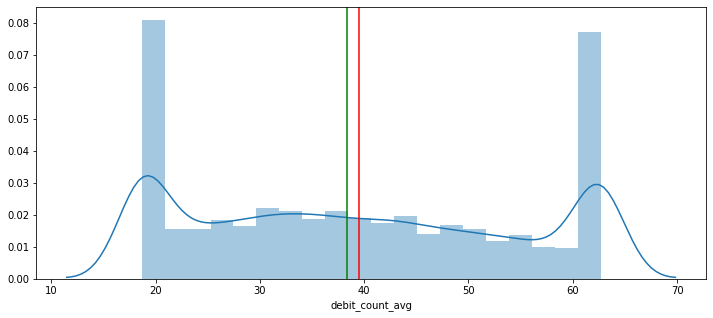

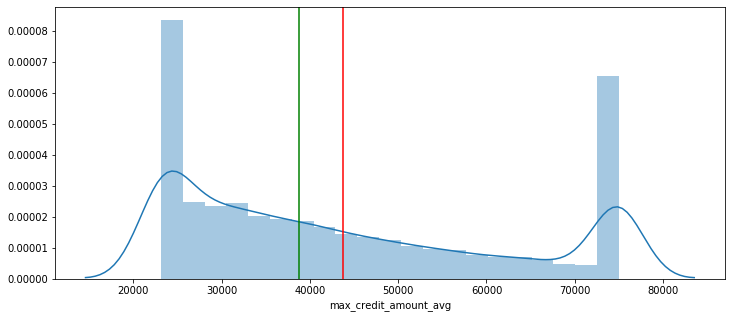

In [40]:
Dist(data)

###### Distribution of data for testing set

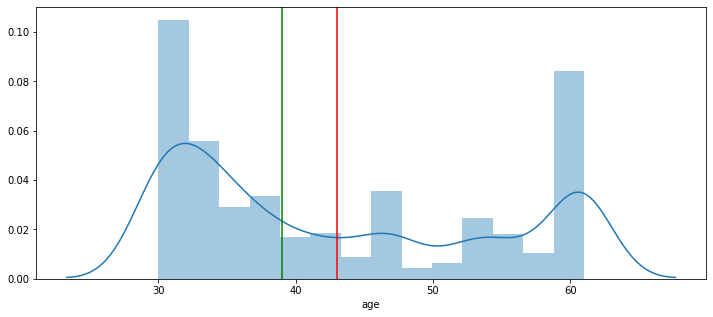

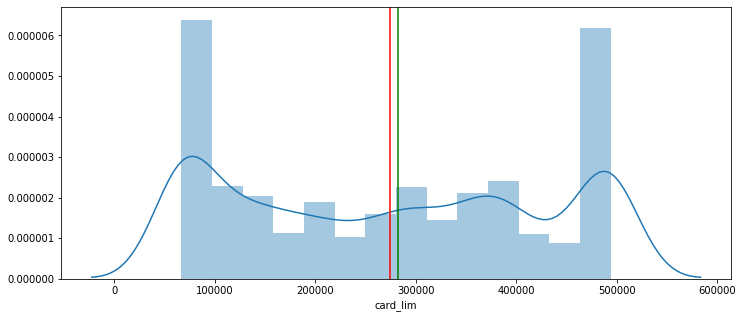

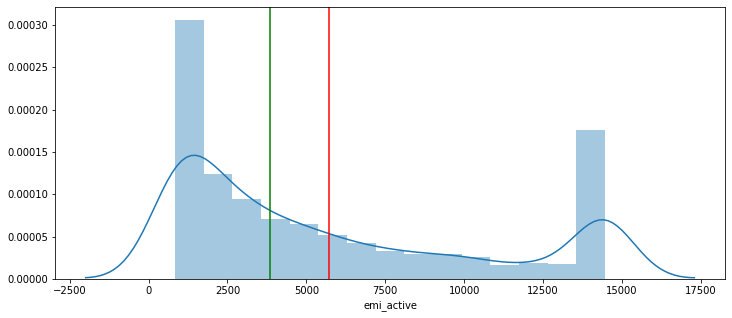

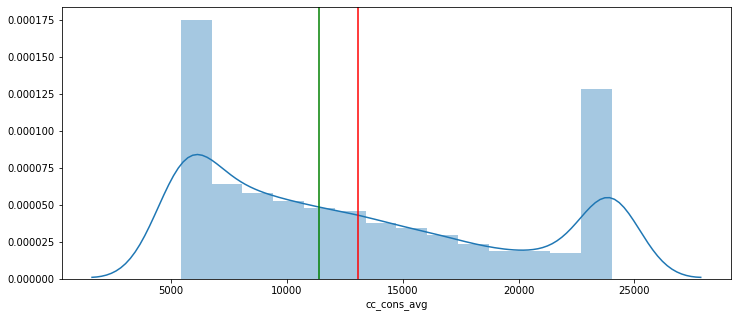

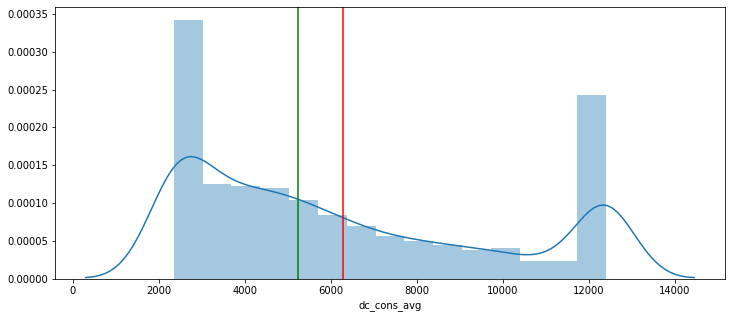

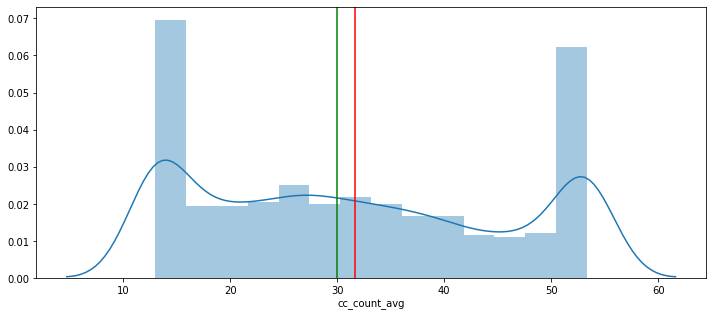

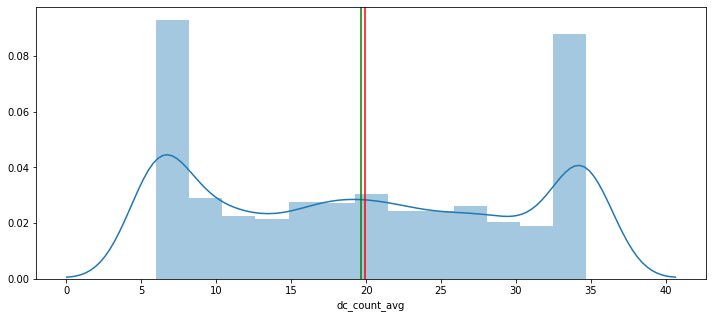

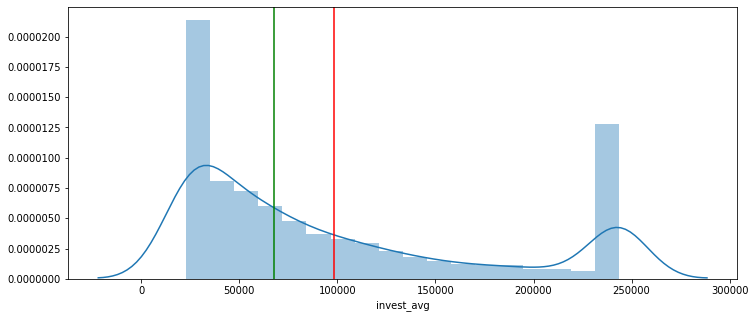

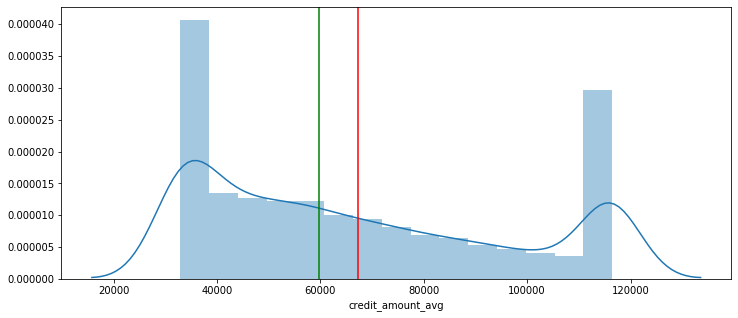

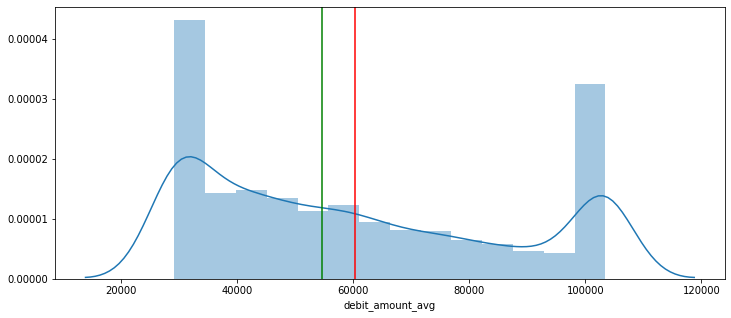

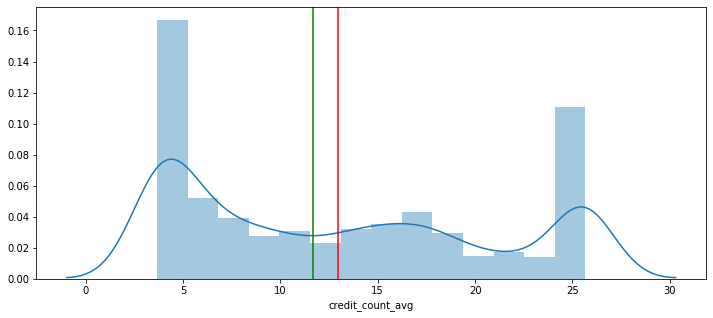

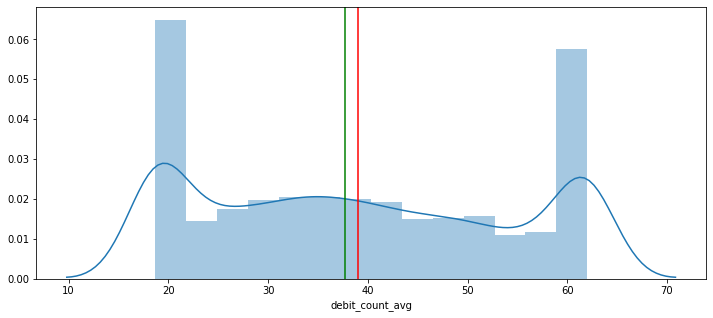

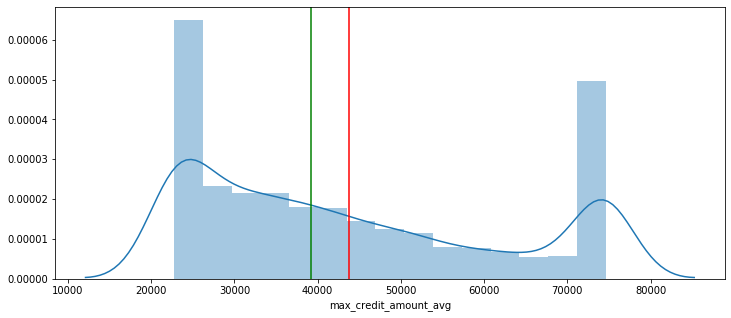

In [41]:
Dist(df)

### Normalize the data for right-skewed features

##### Normalizing Test set

Distribution of train data in each feature after normalization

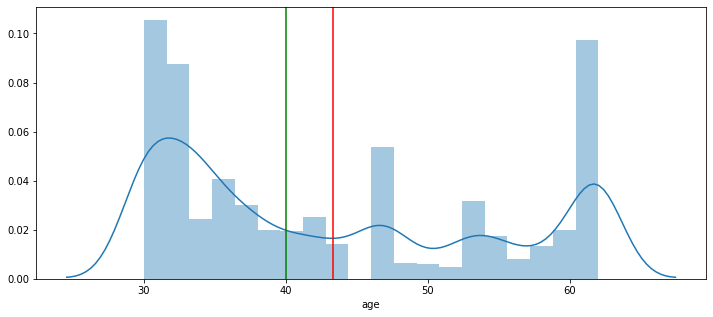

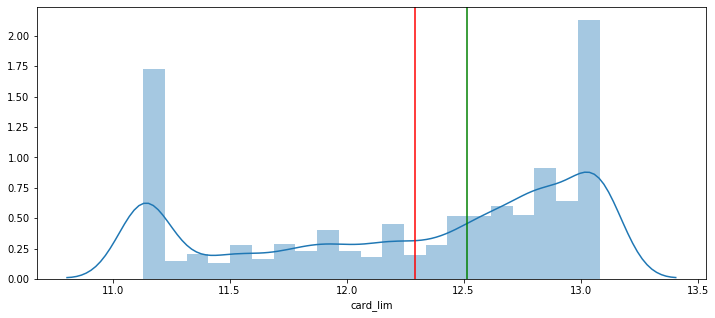

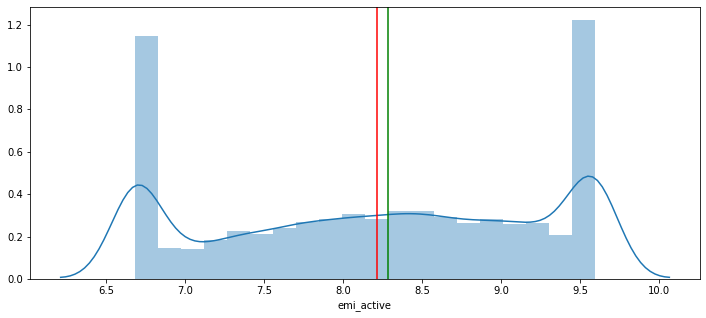

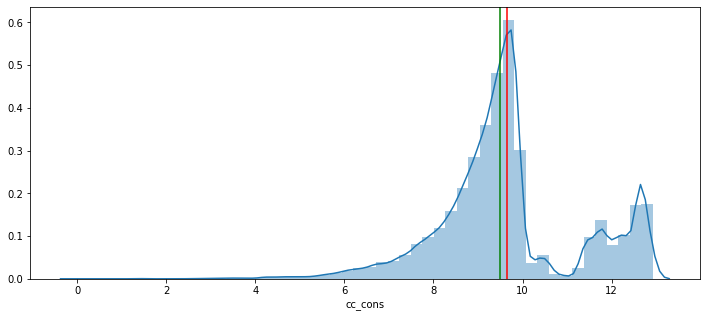

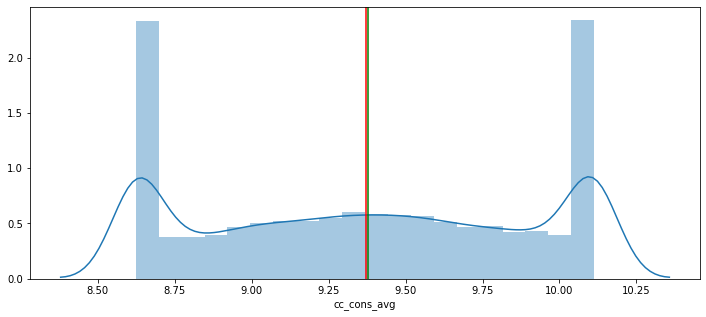

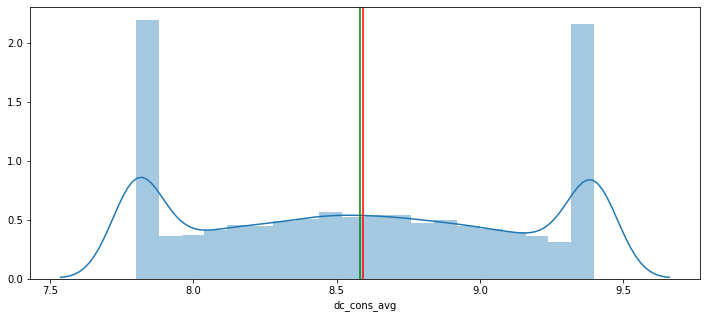

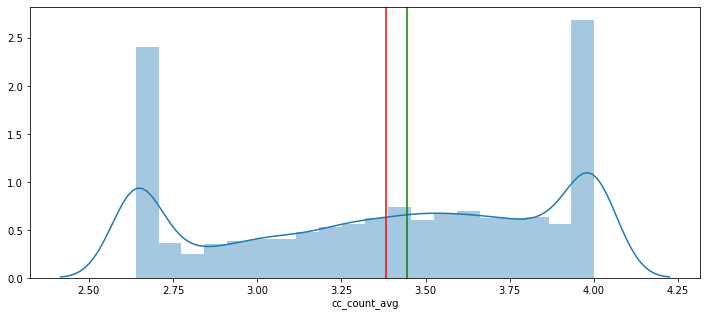

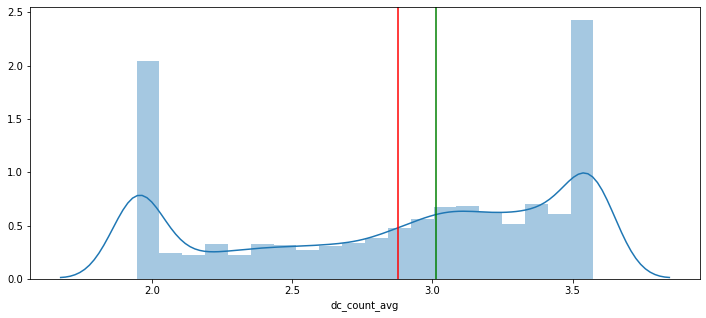

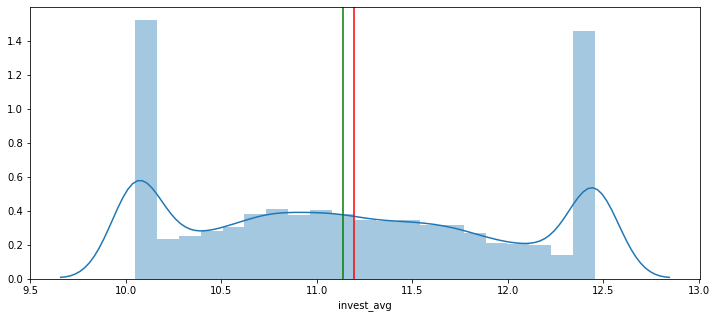

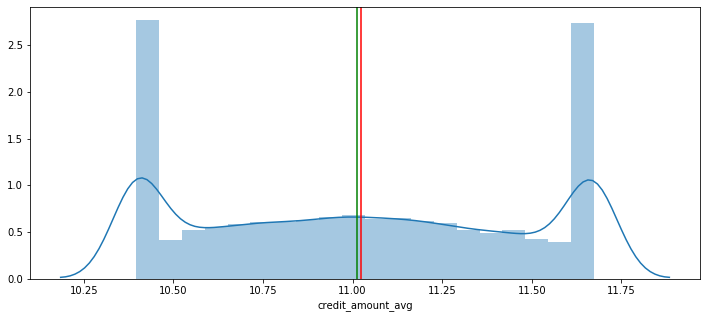

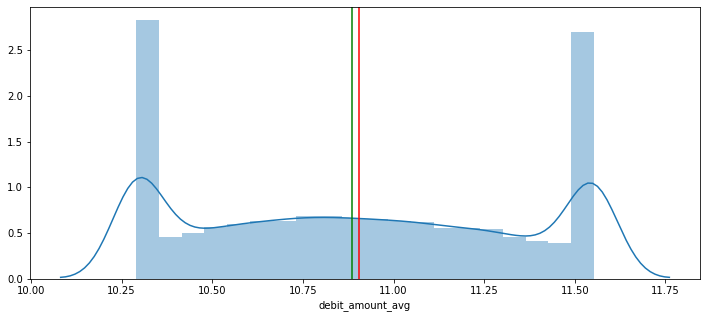

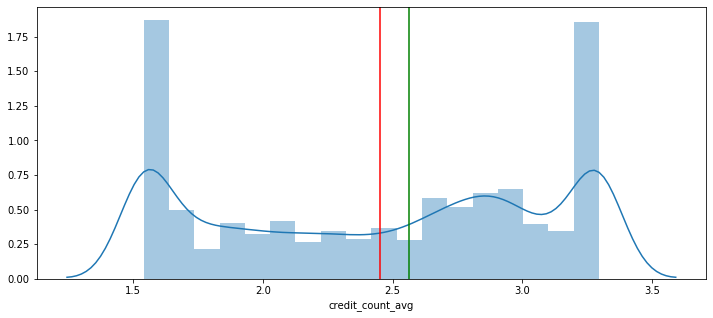

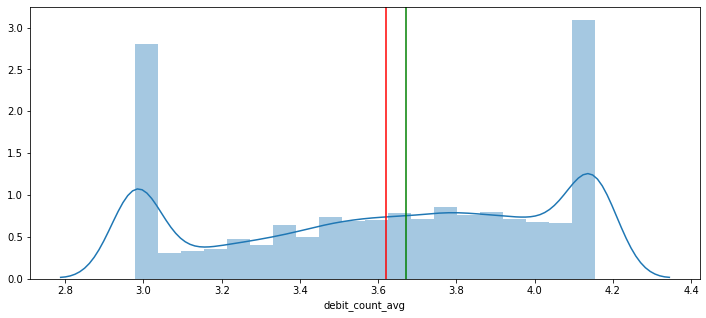

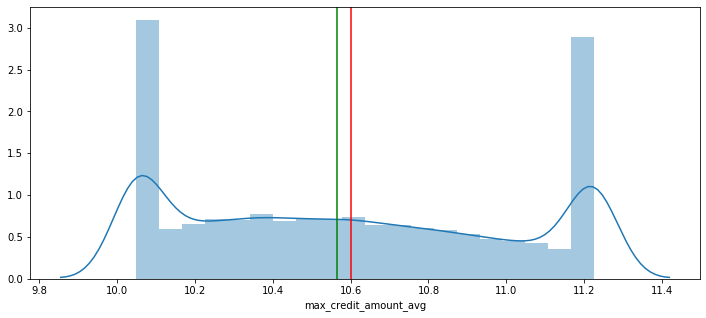

In [42]:
norm(data)

Dist(data)

Distribution of test data in each feature after normalization

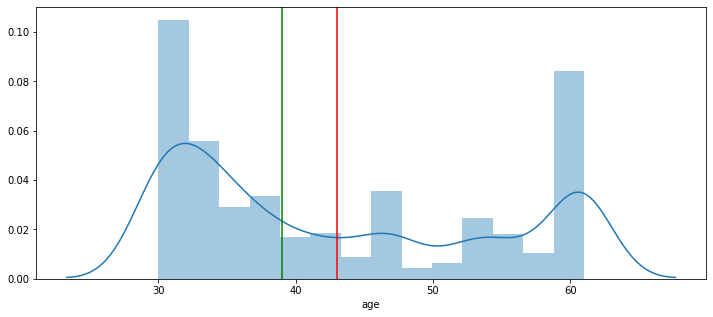

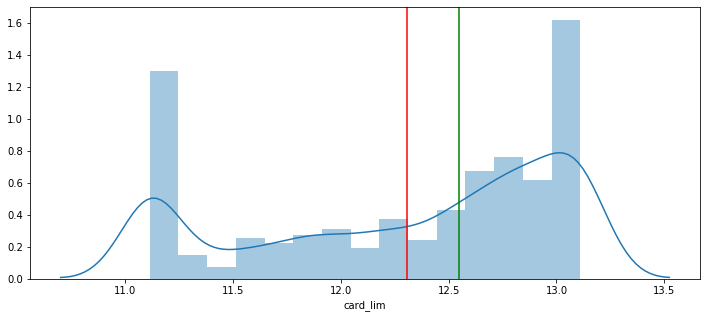

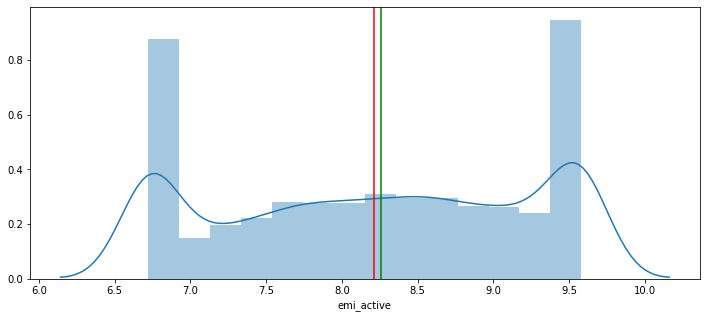

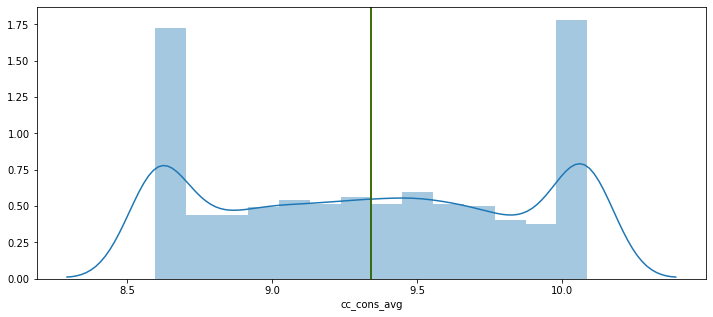

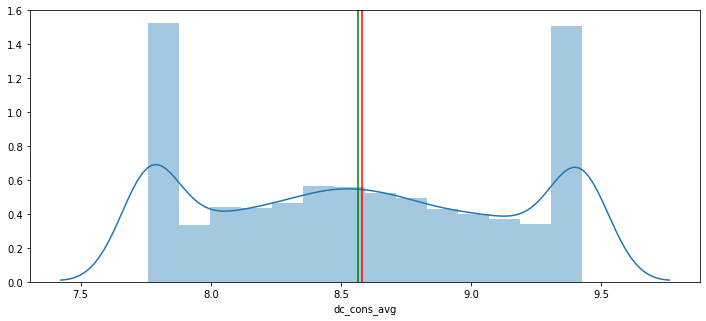

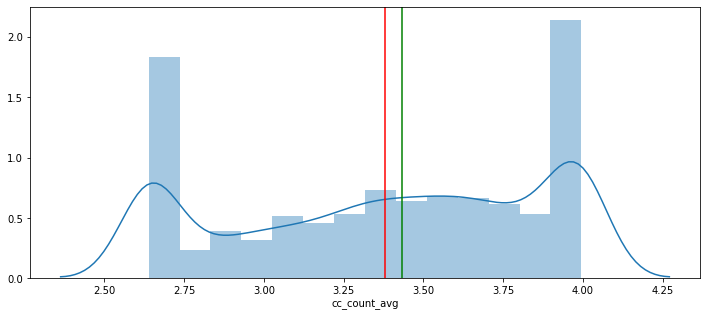

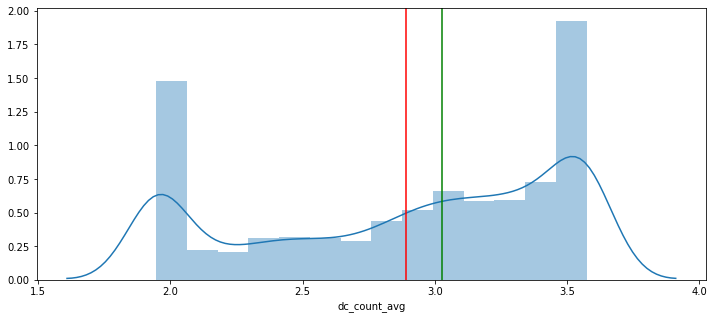

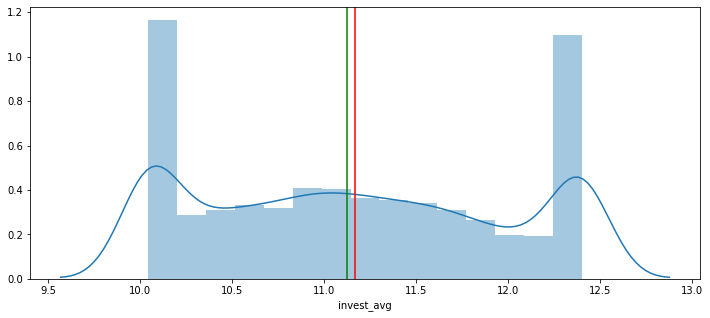

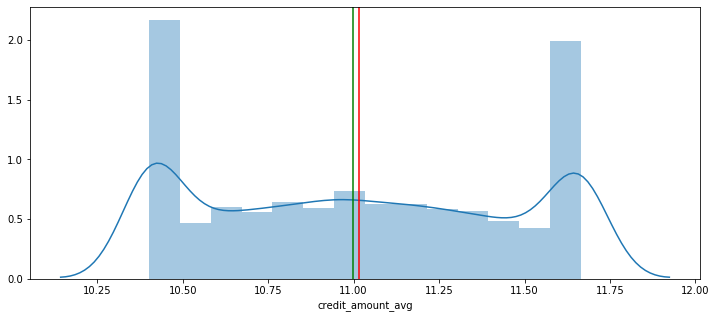

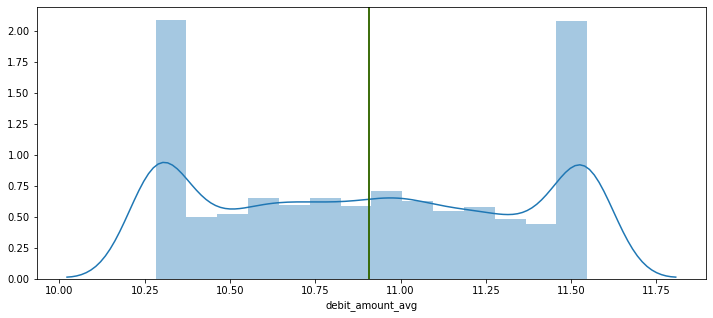

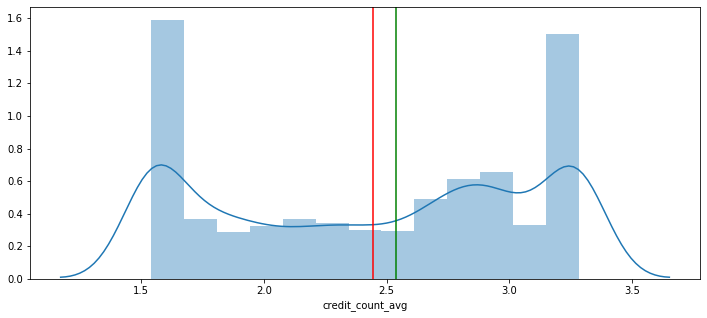

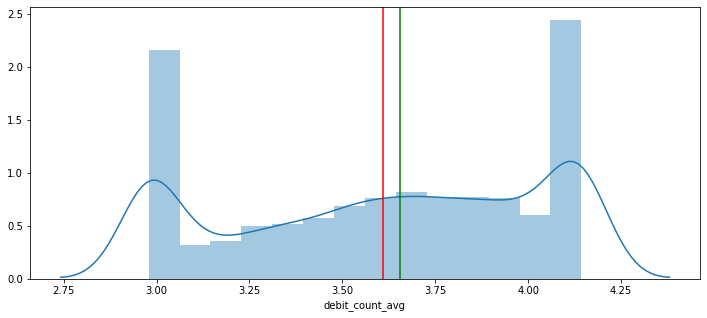

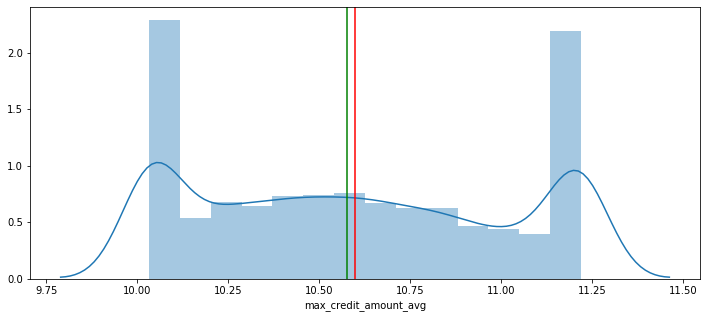

In [43]:
norm(df)

Dist(df)

### Encoding Categorical data

##### Encoding for Train set

In [44]:
encode(data)

,ID,account_type,gender,age,region_code,card_lim,loan_enq,emi_active,cc_cons,cc_cons_avg,dc_cons_avg,cc_count_avg,dc_count_avg,invest_avg,credit_amount_avg,debit_amount_avg,credit_count_avg,debit_count_avg,max_credit_amount_avg
0,12554,0,1,35,708,12.971543,0,7.423622,9.904237,9.750247,9.399597,2.639057,3.574217,10.047532,11.246061,10.657270,1.540445,3.784190,10.421269
1,17645,0,1,35,123,11.755879,0,9.476110,9.227591,9.589544,7.799255,2.639057,2.961831,11.691625,11.273248,10.797222,3.028522,4.088774,10.660603
2,7604,0,1,55,802,12.206073,0,9.594018,9.686326,9.262383,8.279622,4.001254,3.378725,12.021504,11.252184,10.526858,1.945910,3.963983,10.143252
3,1590,0,0,30,867,11.951187,0,8.173387,8.950014,9.913824,8.988340,3.574217,1.945910,11.376754,11.674165,10.639699,3.245193,4.019382,10.494777
4,16556,0,1,34,802,12.601491,0,9.455749,11.476355,8.623409,8.561352,4.001254,3.574217,11.878415,10.940969,11.004045,3.164068,3.776585,10.151298


##### Encoding for Test set

In [45]:
encode(df)

,ID,account_type,gender,age,region_code,card_lim,loan_enq,emi_active,cc_cons_avg,dc_cons_avg,cc_count_avg,dc_count_avg,invest_avg,credit_amount_avg,debit_amount_avg,credit_count_avg,debit_count_avg,max_credit_amount_avg
0,17591,0,1,37,575,11.736077,0,7.066032,8.704259,8.668397,2.639057,3.574217,11.441794,10.574474,10.281803,3.091042,2.978925,10.032657
1,13541,0,1,33,394,11.112463,0,9.580043,9.547423,7.759404,2.639057,3.574217,11.931853,10.938035,10.281803,2.944439,3.721669,10.032657
2,13431,0,1,53,324,11.112463,0,7.872181,8.597865,8.215297,2.708050,2.926739,12.186289,10.514892,11.244323,2.926739,3.378725,10.032657
3,8687,0,1,33,370,13.110293,0,6.723484,9.525948,9.425839,3.995138,1.945910,11.716869,11.111224,11.258911,2.233592,2.978925,11.219905
4,14727,0,1,61,505,11.931642,0,7.942078,8.597865,8.238781,3.028522,2.427748,12.403066,10.401653,11.195131,3.283414,3.721669,10.249179


###### Splitting the data for training set

In [46]:
X = data.drop(['ID','loan_enq',
               'cc_cons'], axis=1)

y = data['cc_cons'].copy()

In [47]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.3, random_state = 0)

### Feature Engineering

In [48]:
data

,ID,account_type,gender,age,region_code,card_lim,loan_enq,emi_active,cc_cons,cc_cons_avg,dc_cons_avg,cc_count_avg,dc_count_avg,invest_avg,credit_amount_avg,debit_amount_avg,credit_count_avg,debit_count_avg,max_credit_amount_avg
0,12554,0,1,35,708,12.971543,0,7.423622,9.904237,9.750247,9.399597,2.639057,3.574217,10.047532,11.246061,10.657270,1.540445,3.784190,10.421269
1,17645,0,1,35,123,11.755879,0,9.476110,9.227591,9.589544,7.799255,2.639057,2.961831,11.691625,11.273248,10.797222,3.028522,4.088774,10.660603
2,7604,0,1,55,802,12.206073,0,9.594018,9.686326,9.262383,8.279622,4.001254,3.378725,12.021504,11.252184,10.526858,1.945910,3.963983,10.143252
3,1590,0,0,30,867,11.951187,0,8.173387,8.950014,9.913824,8.988340,3.574217,1.945910,11.376754,11.674165,10.639699,3.245193,4.019382,10.494777
4,16556,0,1,34,802,12.601491,0,9.455749,11.476355,8.623409,8.561352,4.001254,3.574217,11.878415,10.940969,11.004045,3.164068,3.776585,10.151298
5,19106,0,1,30,958,11.918397,0,8.522678,11.777318,9.335422,7.799255,3.218876,2.662588,11.218880,11.346381,10.607174,2.813411,2.978925,10.048958
6,10086,0,1,32,805,12.138869,0,7.336891,11.639382,8.656746,7.931181,2.639057,3.075775,10.603842,11.458867,10.478348,3.120895,3.308107,10.048958
7,3045,0,1,30,448,11.695255,0,9.594018,8.917847,10.113000,7.799255,3.390024,2.512306,11.430544,10.889715,10.552388,2.079442,4.037186,10.607014
8,17368,0,0,62,631,11.608245,0,8.430347,8.650500,9.743522,8.016307,4.001254,2.036882,10.796095,10.461125,10.675581,3.270836,4.007333,10.048958
9,9756,0,1,37,516,12.043560,0,9.594018,8.942199,10.005943,8.310759,3.506558,3.412247,11.132547,11.032393,11.553640,2.961831,4.153661,10.320738


### Feature Selection

##### RFE

In [49]:
#no of features list
nof_list = [5,10,15,19]

#Variable to store the highest score
high_score = 1

#Variable to store the optimum features
nof = 0 

for n in nof_list:
    # Further splitting the dataset into train and test set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.3, random_state = 0)
    
    # Initialize a Linear Regression model
    model = LinearRegression()

    # Initialize RFE
    rfe = RFE(model, n)

    X_train_rfe = rfe.fit_transform(X_train, y_train)

    X_test_rfe = rfe.transform(X_test)

    # Fit the Linear model to new train set
    model.fit(X_train_rfe, y_train)
    
    y_pred = model.predict(X_test_rfe)

    R_2score = rmsle(y_test, y_pred)

    if R_2score < high_score:
        high_score = R_2score
        nof = n

print("Highest R-squared score :", high_score)
print("Number of features :", nof)

Highest R-squared score : 0.15745722923104755
Number of features : 19


#### ANOVA

In [50]:
skb = SelectPercentile(score_func=f_classif, percentile=90)

# Fit and transform
predictors = skb.fit_transform(X_train, y_train)

# Scores of the features
scores = skb.scores_

# Features
Features = np.asarray(X_train.columns.tolist())

dataframe = pd.DataFrame({'Features': Features, 'scores': scores}).sort_values('scores',ascending=False)

# Top predictors
top_p = dataframe['scores'].quantile(0.7)

top_k_predictors = dataframe[dataframe['scores'] > top_p]['Features'].tolist()

# Display results
print("Top Predictors :\n", top_k_predictors)

Top Predictors :
 ['credit_amount_avg', 'invest_avg', 'max_credit_amount_avg', 'account_type', 'region_code']


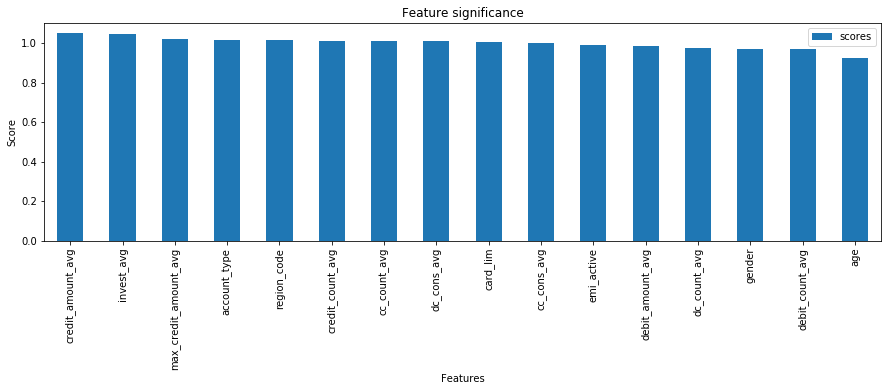

In [51]:
dataframe.set_index('Features').plot(kind='bar', figsize=[15,4])
plt.ylabel('Score')
plt.title('Feature significance')
plt.show()

###### Splitting the data for testing set (Top_k_predictors)

In [52]:
X1 = df.drop(['ID','loan_enq'],axis=1)

In [53]:
X_n = X[top_k_predictors] 
X1_n = X1[top_k_predictors] 

In [54]:
X_tra, X_tes, y_tra, y_tes = train_test_split(X_n, y, test_size=0.3, random_state=7)

### RMSLE

#### Linear Regresson

#### Training and validation model

In [55]:
linreg = LinearRegression()

linreg.fit(X_train1, y_train1)

y_tr = linreg.predict(X_test1)

e = rmsle(y_test1, y_train1)

print('RMSLE score for Linear Regression model(training set) :', rmsle(y_test1, y_train1))

RMSLE score for Linear Regression model(training set) : 0.1446036288407183


#### Testing data

In [56]:
# line = LinearRegression()

# line.fit(X, y)

y_pred = linreg.predict(X1)

#### Lasso Regression

In [57]:
lasso = Lasso()

lasso.fit(X, y)

y_lasso = lasso.predict(X1)

e1 = rmsle(y_test, y_lasso)

print('RMSLE score for Lasso Regression model :', rmsle(y_test, y_lasso))

RMSLE score for Lasso Regression model : 0.14936060286302236


#### Ridge Regression

In [58]:
ridge = Ridge()

ridge.fit(X, y)

y_ridge = ridge.predict(X1)

e2 = rmsle(y, y_ridge)

print('RMSLE score for Ridge Regression model :', rmsle(y, y_ridge))

RMSLE score for Ridge Regression model : 0.15930944992623286


In [59]:
alphas = np.array([0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1])

grid = GridSearchCV(estimator=ridge, param_grid=dict(alpha=alphas))

grid.fit(X, y)

y_grid = grid.predict(X1)

e3 = rmsle(y, y_grid)

print('RMSLE score for Lasso Regression model using CV (testing set) :', rmsle(y, y_grid))

RMSLE score for Lasso Regression model using CV (testing set) : 0.15930944992623286


In [60]:
print(grid.best_score_)

-0.0008694142122741556


In [61]:
print(grid.best_estimator_.alpha)

1.0


#### Top k features model(RFE)

In [62]:
linreg1 = LinearRegression()

linreg1.fit(X_tra, y_tra)

y_tr = linreg1.predict(X_tes)

e4 = rmsle(y_tes, y_tra)

print('RMSLE score for Linear Regression model(training set) :', rmsle(y_tes, y_tra))

RMSLE score for Linear Regression model(training set) : 0.14817810940380438


#### Error

In [63]:
error = {"Models": ["Linear Regression model","Lasso Regression Model","Ridge Regression Model","Grid model","Top k RFE model"],
        "RMSLE score": [e,e1,e2,e3,e4]}

error_1 = pd.DataFrame(error)
error_1

,Models,RMSLE score
0,Linear Regression model,0.144604
1,Lasso Regression Model,0.149361
2,Ridge Regression Model,0.159309
3,Grid model,0.159309
4,Top k RFE model,0.148178


#### Output file

In [64]:
save_to_csv(df)



csv successfully saved. 

